In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mdtraj as mdt
import pytraj as pt
from scipy.special import sph_harm, factorial
from scipy.signal import correlate
import matplotlib.pyplot as plt


import sys
sys.path.append("../analysis")
from rotacf import rotacf
from relax import build_corrs_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
xtc = "/data/gzappavigna/lmp_conf_builder/gmx/amber/step5_production_nojump.xtc"
gro = "/data/gzappavigna/lmp_conf_builder/gmx/amber/step5_production_nojump.gro"

traj = mdt.load(xtc, top=gro)

In [ ]:

# def cart2sph(vecs):
#    x, y, z = np.moveaxis(vecs, 1, 0)

#    x_2 = x ** 2
#    y_2 = y ** 2
#    z_2 = z ** 2

#    xy = np.sqrt(x_2 + y_2)

#    r = np.sqrt(x_2 + y_2 + z_2)
#    theta = np.arctan2(y, x) + np.pi
#    assert np.all((0 <= theta) & (theta <= 2 * np.pi))
#    phi = np.arctan2(xy, z)
#    assert np.all((0 <= phi) & (phi <= np.pi))

#    return r, theta, phi

In [ ]:
# def autocorr(x):
#     result = correlate(x, x, mode='full')
#     C = np.abs(result[result.size // 2:])
#     C /= C[0]
#     return C


# def rotacf(vecs, n=2):
#     _, thetas, phis = cart2sph(vecs)

#     sph_harm_list = []

#     for m in range(-n, n + 1):
#         # sh = sph_harm(m, n, thetas, phis) * np.sqrt(factorial(n + m) / factorial(n - m)) # * (4 * np.pi) / (2 * n + 1))
#         sh = sph_harm(m, n, thetas, phis)

#         sph_harm_list.append(sh)

#     sph_harm_sum = sum(sph_harm_list)

#     return autocorr(sph_harm_sum)


In [25]:
corrs = {}
corrs2 = {}
top = traj.topology

for res in list(top.residues):
    if res.index == 0 or res.name == "PRO":
        continue

    print(res.resSeq)
    n_atom = next(atom for atom in res.atoms if atom.name == "N")
    h_atom = next(atom for atom in res.atoms if atom.name == "H")

    n_coords = traj.xyz[:, n_atom.index]
    h_coords = traj.xyz[:, h_atom.index]

    nh_vec = h_coords - n_coords
    nh_vec /= np.linalg.norm(nh_vec, axis=1, keepdims=True)

    corr, err = rotacf(nh_vec)
    corr2 = pt.timecorr(nh_vec, nh_vec, tcorr=1e5)

    corrs[res.resSeq] = (corr, err)
    corrs2[res.resSeq] = corr2


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
64
65
66
67
68
69
70
71
72
73
74
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
123
124
125
126
127
128
129
130
131
132


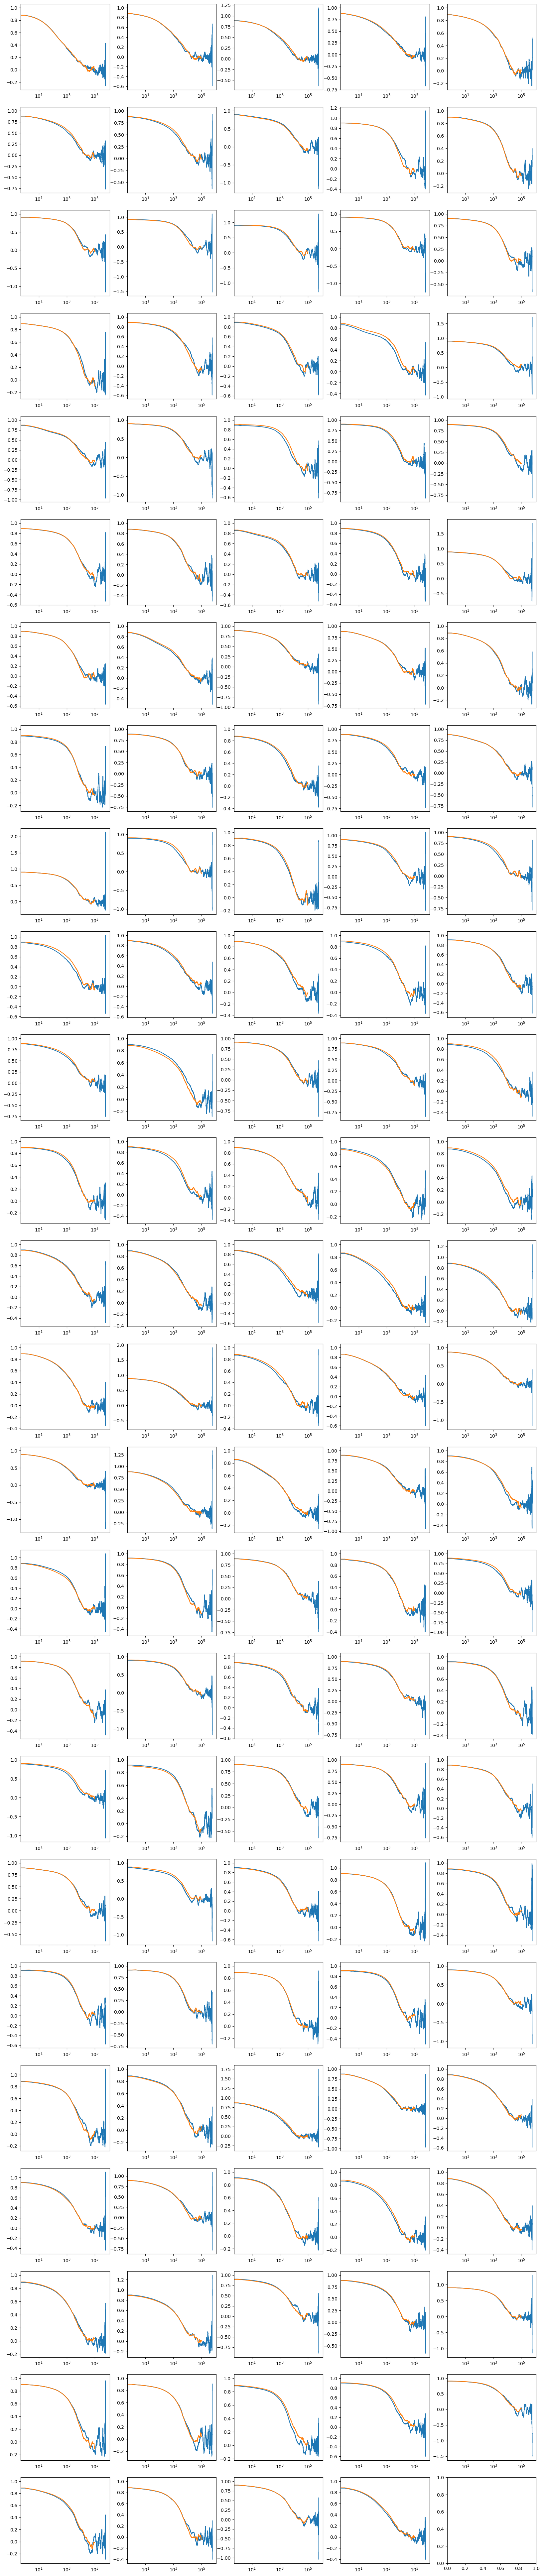

In [26]:
# plt.semilogx(corr / corr[0] * corr2[0])
# plt.semilogx(corr)
# plt.semilogx(corr2 / corr2[0])

ncols = 5
nrows = (len(corrs) + 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

for ax, (resid, (corr, err)), (_, corr2) in zip(axes.flat, corrs.items(), corrs2.items()):

    ax.set_xscale("log")

    t = np.arange(corr.size)
    # ax.errorbar(t, corr, err)
    ax.plot(t, corr)

    t2 = np.arange(corr2.size)
    ax.plot(t2, corr2)
    # ax.vlines(1e4, 0, 1, colors="red")

plt.show()

In [28]:

cum_err = 0.0

for (corr, _), corr2 in zip(corrs.values(), corrs2.values()):
    size = min(corr.size, corr2.size)

    cum_err += np.sum((corr[:size] - corr2[:size]) ** 2)

print(np.sqrt(cum_err))


202.64171894375437
